# **Binary Segmentation with Carvana Dataset**

In this notebook, a model based on the [U-Net](https://arxiv.org/abs/1505.04597) architecture is trained from scratch for the binary semantic segmentation task using the [Carvana Image Masking](https://www.kaggle.com/competitions/carvana-image-masking-challenge/) dataset. This dataset contains 105,152 high-resolution images of cars from various brands, of which 5,088 images are designated for training and 100,064 for testing. However, only the training set includes binary masks associated with a single class, **car**, which are publicly available. Consequently, the original training set is split into 80% for training and 20% for validation. This dataset is ideal for training basic segmentation models because the masks are binary, only one type of object (a car per image) is segmented, and the cars appear against a uniform and mostly clean background in all images.

## **Imports**

In [ ]:
# Install the Torchview library to visualize the model architecture
!pip install torchview -q

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import LambdaLR
from torchsummary import summary
from torchview import draw_graph
import albumentations as A
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from google.colab import drive
from tqdm import tqdm
import copy
import os
from PIL import Image
import requests
import io

# To prevent the model architecture image from being cropped
import graphviz
graphviz.set_jupyter_format("png")

## **Parameters**

In [ ]:
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
zip_dataset_path = "/content/drive/MyDrive/Datasets/Carvana.zip"
dataset_dir = os.path.basename(zip_dataset_path).split(".")[0]
trained_model_path = "/content/drive/MyDrive/models/BinarySegmentation_U-Net_Carvana.pth"
epochs = 50
batch_size = 16
patience = 7
image_size = (3, 384, 384)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## **Prepare the Dataset for Training**

### **Load the Dataset**

The download and all preliminary preprocessing of the Carvana dataset were completed in the following notebook: [Preprocessing_Carvana](https://github.com/JersonGB22/ImageSegmentation-TensorFlow-PyTorch/blob/main/Preprocessing/Preprocessing_Carvana.ipynb).

In [ ]:
# Unzip the dataset
!unzip -q $zip_dataset_path

In [ ]:
# Obtain the training and validation DataFrames
df_data = pd.read_csv(os.path.join(dataset_dir, "metadata.csv"))
df_train = df_data[df_data.split == "train"]
df_val = df_data[df_data.split == "val"]

df_data

image_path  \
0     /content/Carvana/images/2990f858e939_05.jpg   
1     /content/Carvana/images/2f39abb12388_07.jpg   
2     /content/Carvana/images/6131a03dd028_10.jpg   
3     /content/Carvana/images/69915dab0755_07.jpg   
4     /content/Carvana/images/eb07e3f63ad2_04.jpg   
...                                           ...   
5083  /content/Carvana/images/f98dbe8a5ee2_01.jpg   
5084  /content/Carvana/images/419687d50dcd_16.jpg   
5085  /content/Carvana/images/784ca55262c2_02.jpg   
5086  /content/Carvana/images/8d78483ce302_01.jpg   
5087  /content/Carvana/images/32edfb7723ff_10.jpg   

                                            mask_path  split  
0     /content/Carvana/masks/2990f858e939_05_mask.png  train  
1     /content/Carvana/masks/2f39abb12388_07_mask.png  train  
2     /content/Carvana/masks/6131a03dd028_10_mask.png  train  
3     /content/Carvana/masks/69915dab0755_07_mask.png  train  
4     /content/Carvana/masks/eb07e3f63ad2_04_mask.png  train  
...                                               ...    ...  
5083  /content/Carvana/masks/f98dbe8a5ee2_01_mask.png    val  
5084  /content/Carvana/masks/419687d50dcd_16_mask.png    val  
5085  /content/Carvana/masks/784ca55262c2_02_mask.png    val  
5086  /content/Carvana/masks/8d78483ce302_01_mask.png    val  
5087  /content/Carvana/masks/32edfb7723ff_10_mask.png    val  

[5088 rows x 3 columns]

In [ ]:
# Define the classes and their respective colors
classes = {
    "background": [0, 0, 32],
    "car": [0, 0, 255]
}

class_names = list(classes.keys())
class_colors = np.array(list(classes.values()))
num_classes = len(class_names)
background_class = class_names.index("background")

### **Create the Training and Validation Datasets**

A custom class is created to build the datasets, load and preprocess the images and their segmentation masks, preparing them for training. To combat overfitting and improve model performance, the [Albumentations](https://albumentations.ai/docs/) library will be used. This is a fast and flexible image augmentation library that is widely used in Deep Learning.

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, image_paths, mask_paths, image_size, transform=None):
    self.image_paths = image_paths
    self.mask_paths = mask_paths
    self.image_size = image_size[1:]
    self.transform = transform

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx):
    image = cv2.imread(self.image_paths[idx])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, self.image_size)

    mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, self.image_size, interpolation=cv2.INTER_NEAREST)

    if self.transform:
      transformed = self.transform(image=image, mask=mask)
      image = transformed["image"]
      mask = transformed["mask"]

    image = torch.tensor(image, dtype=torch.float32) / 255
    image = image.permute(2, 0, 1)
    mask = torch.tensor(mask, dtype=torch.long)

    return image, mask


transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(
        shift_limit=0.15,
        scale_limit=0.1,
        rotate_limit=15,
        border_mode=cv2.BORDER_CONSTANT,
        mask_interpolation=cv2.INTER_NEAREST,
        value=background_class,
        p=0.5
    ),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.3, p=0.5),
], p=1.0)

In [ ]:
train_dataset = CustomDataset(
    df_train.image_path.values,
    df_train.mask_path.values,
    image_size=image_size,
    transform=transform
)
val_dataset = CustomDataset(
    df_val.image_path.values,
    df_val.mask_path.values,
    image_size=image_size,
)

num_workers = os.cpu_count() // 2
print(len(train_dataset), len(val_dataset), num_workers)

train_dataset = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers
)
val_dataset = DataLoader(
    val_dataset,
    batch_size=batch_size,
    num_workers=num_workers
)

4070 1018 1


In [ ]:
# Take a batch from the training dataset
images, masks = next(iter(train_dataset))

print(images.shape)
print(masks.shape)

torch.Size([16, 3, 384, 384])
torch.Size([16, 384, 384])


In [ ]:
# Function to plot images with their segmentation masks
def plot_image_masks(images, masks, masks_pred=None, n_rows=3, random=True, blended=False,
                     alpha=0.7, metric=None, preprocess=False, save=False, path_save=""):

  indices = np.arange(len(images))
  if random:
    np.random.shuffle(indices)

  n_cols = 2 if masks_pred is None else 3
  titles = ["Image", "True Mask"] + ([] if masks_pred is None else ["Pred Mask"])

  fig, axes = plt.subplots(n_rows, n_cols, figsize=(3.25 * n_cols, 3.25 * n_rows))
  for col, title in enumerate(titles):
    axes[0, col].set_title(title, fontsize=10)

  for i in range(n_rows):
    idx = indices[i]
    image = images[idx].permute(1, 2, 0).numpy()
    mask_cls = masks[idx].numpy()
    mask_rgb = class_colors[mask_cls] / 255
    shape = image.shape

    if blended:
      mask_rgb = mask_rgb.astype(image.dtype)
      mask_rgb[mask_cls == background_class] = image[mask_cls == background_class]
      mask_rgb = cv2.addWeighted(image, 1 - alpha, mask_rgb, alpha, 0)

    axes[i, 0].imshow(image)
    axes[i, 0].axis("off")
    axes[i, 1].imshow(mask_rgb)
    axes[i, 1].axis("off")

    if masks_pred is not None:
      mask_cls_pred = masks_pred[idx].numpy()
      mask_rgb_pred = class_colors[mask_cls_pred] / 255

      if blended:
        mask_rgb_pred = mask_rgb_pred.astype(image.dtype)
        mask_rgb_pred[mask_cls_pred == background_class] = image[mask_cls_pred == background_class]
        mask_rgb_pred = cv2.addWeighted(image, 1 - alpha, mask_rgb_pred, alpha, 0)

      axes[i, 2].imshow(mask_rgb_pred)
      axes[i, 2].axis("off")

      if metric is not None:
        metric.reset()
        metric.update(torch.tensor(mask_cls_pred), torch.tensor(mask_cls), preprocess=preprocess)

        axes[i, 2].text(
          x=shape[1]/2, y=shape[0],
          s=f"{metric.metric_name.replace('_', ' ')}: {metric.compute().item():.3f}",
          fontsize=7, ha="center", va="top",
        )

  plt.tight_layout()
  # Save images
  if save:
    plt.savefig(path_save)

  plt.show()

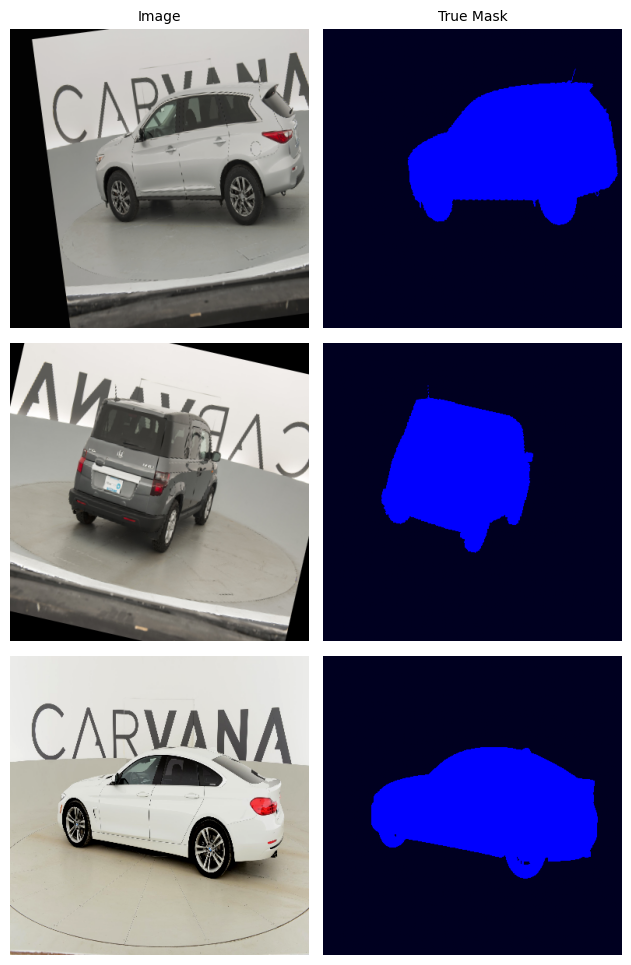

In [ ]:
# Some images and masks from the training dataset after data augmentation
plot_image_masks(images, masks)

## **Build the Model**

The architecture of the [U-Net](https://arxiv.org/abs/1505.04597) model consists of a contraction path (encoder) to capture context and a symmetric expansion path (decoder) that allows for precise localization. To improve the model's performance, an additional convolutional block is added to both the encoder and the decoder, bringing the total number of blocks to five, compared to the four in the original U-Net model. Additionally, two **Batch Normalization** layers are incorporated into each convolutional block to help mitigate **overfitting** and **gradient vanishing**, common issues in deep neural networks. This modified U-Net architecture is generic and can be used for both binary and multiclass semantic segmentation tasks.

![U-Net](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)
*Original U-Net model*

In [ ]:
# Convolutional block with optional Batch Normalization for feature extraction
class Conv2dBlock(nn.Module):
  def __init__(self, in_channels, out_channels, use_bn):
    super().__init__()

    layers = [
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
    ]
    if use_bn:
      layers.insert(1, nn.BatchNorm2d(out_channels))
      layers.insert(-1, nn.BatchNorm2d(out_channels))

    self.block = nn.Sequential(*layers)

  def forward(self, x):
    x = self.block(x)
    return x


# Encoder block consisting of a convolutional block followed by max pooling
class EncoderBlock(nn.Module):
  def __init__(self, in_channels, out_channels, use_bn):
    super().__init__()
    self.block = Conv2dBlock(in_channels, out_channels, use_bn=use_bn)
    self.pool = nn.MaxPool2d(kernel_size=2)

  def forward(self, x):
    enc = self.block(x)
    pool = self.pool(enc)
    return enc, pool


# Decoder block consisting of transposed convolution followed by concatenation with encoder features
class DecoderBlock(nn.Module):
  def __init__(self, in_channels, out_channels, use_bn):
    super().__init__()
    self.conv_trans = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
    self.relu = nn.ReLU(inplace=True)
    self.block = Conv2dBlock(out_channels * 2, out_channels, use_bn=use_bn)

  def forward(self, x, enc):
    x = self.conv_trans(x)
    x = self.relu(x)
    x = torch.concat([x, enc], dim=1)
    x = self.block(x)
    return x


# U-Net architecture composed of encoder and decoder blocks, for semantic segmentation
class UNet(nn.Module):
  def __init__(self, num_classes, filters=32, use_bn=True):
    super().__init__()

    self.enc1 = EncoderBlock(3, filters, use_bn=use_bn)
    self.enc2 = EncoderBlock(filters, filters * 2, use_bn=use_bn)
    self.enc3 = EncoderBlock(filters * 2, filters * 4, use_bn=use_bn)
    self.enc4 = EncoderBlock(filters * 4, filters * 8, use_bn=use_bn)
    self.enc5 = EncoderBlock(filters * 8, filters * 16, use_bn=use_bn)

    self.bottleneck = Conv2dBlock(filters * 16, filters * 32, use_bn=use_bn)

    self.dec5 = DecoderBlock(filters * 32, filters * 16, use_bn=use_bn)
    self.dec4 = DecoderBlock(filters * 16, filters * 8, use_bn=use_bn)
    self.dec3 = DecoderBlock(filters * 8, filters * 4, use_bn=use_bn)
    self.dec2 = DecoderBlock(filters * 4, filters * 2, use_bn=use_bn)
    self.dec1 = DecoderBlock(filters * 2, filters, use_bn=use_bn)

    self.output_layer = nn.Conv2d(filters, num_classes, kernel_size=1)

  def forward(self, x):
    enc1, pool1 = self.enc1(x)
    enc2, pool2 = self.enc2(pool1)
    enc3, pool3 = self.enc3(pool2)
    enc4, pool4 = self.enc4(pool3)
    enc5, pool5 = self.enc5(pool4)

    bottleneck = self.bottleneck(pool5)

    dec5 = self.dec5(bottleneck, enc5)
    dec4 = self.dec4(dec5, enc4)
    dec3 = self.dec3(dec4, enc3)
    dec2 = self.dec2(dec3, enc2)
    dec1 = self.dec1(dec2, enc1)

    outputs = self.output_layer(dec1)
    return outputs

In [ ]:
# Initialize the U-Net model and display its architecture summary
model = UNet(num_classes).to(device)
summary(model, input_size=image_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 384, 384]             896
       BatchNorm2d-2         [-1, 32, 384, 384]              64
              ReLU-3         [-1, 32, 384, 384]               0
            Conv2d-4         [-1, 32, 384, 384]           9,248
       BatchNorm2d-5         [-1, 32, 384, 384]              64
              ReLU-6         [-1, 32, 384, 384]               0
       Conv2dBlock-7         [-1, 32, 384, 384]               0
         MaxPool2d-8         [-1, 32, 192, 192]               0
      EncoderBlock-9  [[-1, 32, 384, 384], [-1, 32, 192, 192]]               0
           Conv2d-10         [-1, 64, 192, 192]          18,496
      BatchNorm2d-11         [-1, 64, 192, 192]             128
             ReLU-12         [-1, 64, 192, 192]               0
           Conv2d-13         [-1, 64, 192, 192]          36,928
      BatchNorm2d-14    

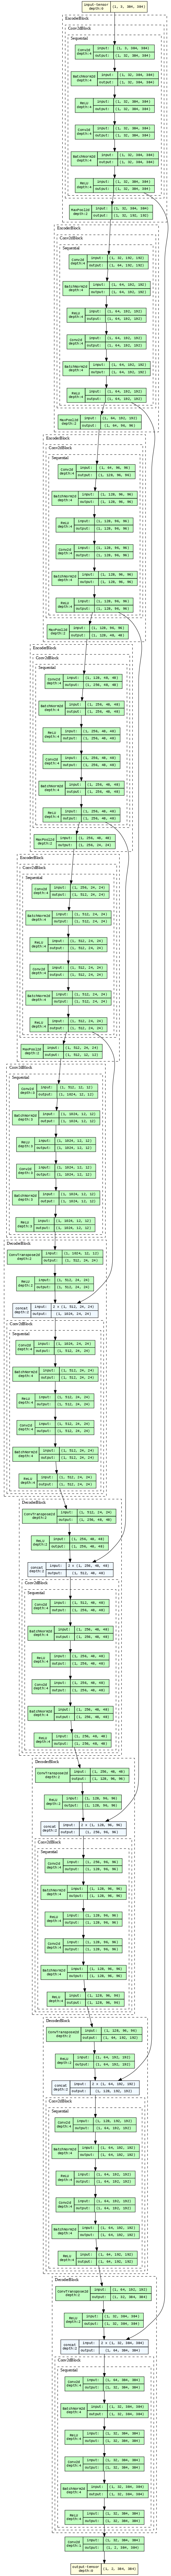

In [ ]:
# Visualize the model architecture
model_graph = draw_graph(model, input_size=(1,)+image_size, expand_nested=True, depth=4)
model_graph.visual_graph

## **Create the Segmentation Metrics and Loss**

In [ ]:
# Function to avoid division by zero
def divide_no_nan(num, den):
  return torch.where(den != 0, num / den, 0)

In image semantic segmentation, the most commonly used metrics to evaluate model performance are **Mean IoU** and **Dice Score**.  

1. **Mean IoU:** Mean IoU (Intersection over Union) measures the overlap between the predicted areas and the ground truth areas for each class and averages the results across all classes. It is a standard metric in semantic segmentation. Its general formula for the multiclass case is:  
   $$
   Mean\ IoU = \frac{1}{C} \sum_{c=1}^C \frac{|P_c \cap T_c|}{|P_c \cup T_c|}
   $$
   Where:  
   - $C$ is the number of classes.  
   - $P_c$ and $T_c$ represent the predicted areas and the ground truth areas for class $c$.  
   - $|P_c \cap T_c|$ is the intersection area between the prediction and the ground truth.  
   - $|P_c \cup T_c|$ is the union area between the prediction and the ground truth.  

2. **Dice Score:** Dice Score (or Dice Coefficient) is another common metric that measures the similarity between predicted and true areas. It is particularly useful for imbalanced datasets. Its general formula for the multiclass case is:  
   $$
   Dice\ Score = \frac{1}{C} \sum_{c=1}^C \frac{2 |P_c \cap T_c|}{|P_c| + |T_c|}
   $$
   The terms are the same as in Mean IoU, but Dice Score is more sensitive to small differences between the prediction and the ground truth.  

A custom class implemented in PyTorch is introduced below to calculate these metrics, designed to work for both binary and multiclass segmentation. Key features of this class include:  

- **Support for ignored classes:** Specific classes, such as the background or unlabeled regions, can be excluded from the metric calculations. An example of this case can be seen in the notebook [SemanticSegmentation_SegFormer-B2_CamVid](https://github.com/JersonGB22/ImageSegmentation-TensorFlow-PyTorch/blob/main/SemanticSegmentation/SemanticSegmentation_SegFormer-B2_CamVid.ipynb)

- **Handling absent classes:** If one or more classes are missing in the input masks, the metric returns a NaN value for that class, ensuring it is excluded from the final calculation. This is particularly useful in multiclass segmentation, where individual masks or batches may not include all classes in a specific dataset. A specific case can be seen in the notebook [SemanticSegmentation_SegFormer-B2_LandCover.ai](https://github.com/JersonGB22/ImageSegmentation-TensorFlow-PyTorch/blob/main/SemanticSegmentation/SemanticSegmentation_SegFormer-B2_LandCover.ai.ipynb)

In [ ]:
# Custom class to calculate Mean IoU or Dice Score
class SegmentationMetrics():
  def __init__(self, metric_name, num_classes, ignore_class=None, device=None):
    if metric_name not in {"mean_iou", "dice_score"}:
      raise ValueError("Invalid metric. Choose 'mean_iou' or 'dice_score'.")

    self.metric_name = metric_name
    self.num_classes = num_classes
    self.ignore_class = ignore_class
    self.device = device
    
    # Initialize tensors to store cumulative intersection and combined areas
    self.intersect_area_total = torch.zeros(num_classes, dtype=torch.float32, device=device)
    self.combined_area_total = torch.zeros(num_classes, dtype=torch.float32, device=device)

  def update(self, y_pred, y_true, preprocess=True):
    y_true = y_true.to(self.device)
    y_pred = y_pred.to(self.device)
    
    # Convert logits to class predictions if preprocessing is enabled
    if preprocess:
      y_pred = y_pred.argmax(dim=1)
    
    # Flatten predictions and labels
    y_true = y_true.view(-1).long()
    y_pred = y_pred.view(-1).long()
    
    # Apply mask to ignore specific class, if configured
    if self.ignore_class is not None:
      mask = (y_true != self.ignore_class)
      y_true = y_true[mask]
      y_pred = y_pred[mask]
    
    # Convert to one-hot encoding for multiclass processing
    y_true = F.one_hot(y_true, self.num_classes).float()
    y_pred = F.one_hot(y_pred, self.num_classes).float()
    
    # Calculate intersection and combined areas
    intersect_area = torch.sum(y_true * y_pred, dim=0)
    combined_area = torch.sum(y_true + y_pred, dim=0)
    
    # Update cumulative totals
    self.intersect_area_total += intersect_area
    self.combined_area_total += combined_area
  
  # Compute metric for each class
  def compute_by_class(self):
    if self.metric_name == "mean_iou":
      union_area_total = self.combined_area_total - self.intersect_area_total
      metric = divide_no_nan(self.intersect_area_total, union_area_total)
    else:
      metric = divide_no_nan(2 * self.intersect_area_total, self.combined_area_total)
    
    # Assign NaN to classes with no samples
    metric = torch.where(self.combined_area_total > 0, metric, torch.tensor(float("nan"), dtype=metric.dtype))
    return metric
  
  # Calculate average metric across valid classes
  def compute(self):
    metric = self.compute_by_class()
    metric = metric[metric.isnan().logical_not()]
    return metric.mean()
  
  # Reset accumulated values
  def reset(self):
    self.intersect_area_total.zero_()
    self.combined_area_total.zero_()


# Custom class to calculate Accuracy with the option to ignore a class
class Accuracy():
  def __init__(self, ignore_class=None, device=None):
    self.ignore_class = ignore_class
    self.device = device

    # Initialize cumulative counters for true positives and total samples
    self.total_true_positives = torch.zeros((), dtype=torch.float32, device=device)
    self.total = torch.zeros((), dtype=torch.float32, device=device)

  def update(self, y_pred, y_true):
    y_true = y_true.to(self.device)
    y_pred = y_pred.to(self.device)

    # Convert logits to class predictions
    y_pred = y_pred.argmax(dim=1)
    
    # Create mask for ignored classes if specified
    if self.ignore_class is not None:
      mask = (y_true != self.ignore_class).float()
    else:
      mask = torch.ones_like(y_true).float()
    
    # Calculate true positives and apply mask
    true_positives = (y_true == y_pred).float()
    true_positives = (true_positives * mask).sum()
    total = mask.sum()
    
    # Update cumulative counters
    self.total_true_positives += true_positives
    self.total += total
  
  # Compute accuracy
  def compute(self):
    return divide_no_nan(self.total_true_positives, self.total)
  
  # Reset accumulated values
  def reset(self):
    self.total_true_positives.zero_()
    self.total.zero_()

As stated in [Sudre et al., 2017](https://arxiv.org/pdf/1707.03237), traditional losses such as weighted cross-entropy may be inadequate for semantic segmentation tasks due to class imbalance, which is common in applications like medical image segmentation. In these cases, minority classes may be insufficiently penalized, leading to poor segmentation performance. The **Generalized Dice Loss** addresses this issue by dynamically adjusting class weights, making it more sensitive to minority classes while maintaining strong performance on dominant classes, achieving better results in scenarios involving imbalanced classes and complex data distributions.

The **Generalized Dice Loss** is defined as:

$$
GDL = 1 - 2 \cdot \frac{\sum_{c=1}^{C} w_c \cdot \sum_i g_{ic} p_{ic}}{\sum_{c=1}^{C} w_c \cdot \sum_i (g_{ic} + p_{ic})}
$$

Where:

- $C$ is the total number of classes.
- $g_{ic}$ is the binary ground truth for pixel $i$ of class $c$.
- $p_{ic}$ is the predicted probability for pixel $i$ of class $c$.
- $w_c$ is a weight defined as:

 $$w_c = \frac{1}{\left(\sum_i g_{ic}\right)^2}$$
 
This weighting compensates for class imbalance by giving greater importance to minority classes during loss computation. 

However, it is important to note that this loss is not suitable when there is a need to ignore a class. This is the case, for example, in scenarios where classes like the background or unlabeled categories must be excluded. It is also unsuitable when not all classes of a specific dataset are present in each segmentation mask or batch of masks.

In [ ]:
def generalized_dice_loss(y_pred, y_true, num_classes):
  # Convert ground truth to one-hot encoding 
  y_true_ohe = F.one_hot(y_true.long(), num_classes).float()
  y_true_ohe = y_true_ohe.permute(0, 3, 1, 2) #(batch_size, num_classes, H, W)
  
  # Apply softmax to predicted logits
  y_pred = y_pred.softmax(dim=1)
  
  # Calculate the class weights and areas
  intersect_area = torch.sum(y_true_ohe * y_pred, dim=[0, 2, 3])
  combined_area = torch.sum(y_true_ohe + y_pred, dim=[0, 2, 3])
  w = divide_no_nan(1, torch.sum(y_true_ohe, dim=[0, 2, 3]) ** 2) 
  
  # Apply weights to areas, automatically ignoring classes that are not present
  weighted_intersect = torch.sum(w * intersect_area)
  weighted_combined = torch.sum(w * combined_area)
  
  # Compute the Generalized Dice Loss
  loss = 1 - (2 * divide_no_nan(weighted_intersect, weighted_combined))
  return loss

## **Train the Model**

In [ ]:
# Function to execute a training or validation epoch
def train_one_epoch(model, dataset, optimizer, lr_scheduler, accuracy,
                    seg_metric, num_classes, training, device):
  
  # Set the model to training or validation mode
  if training:
    model.train()
  else:
    model.eval()

  # Reset the accuracy and segmentation metric
  accuracy.reset()
  seg_metric.reset()

  # Initialize epoch loss
  loss_epoch, step = (0, 0)

  with tqdm(dataset, desc="Train" if training else "  Val") as pbar:
    for images, masks in pbar:
      cur_batch_size = len(images)
      images = images.to(device)
      masks = masks.to(device)

      # Reset optimizer gradients
      optimizer.zero_grad()

      # Enable gradient computation if the model is in training mode
      with torch.set_grad_enabled(training):
        masks_pred = model(images) #Forward

        # Compute loss
        loss = generalized_dice_loss(masks_pred, masks, num_classes)

        # Backward
        if training:
          loss.backward()
          optimizer.step()
          lr_scheduler.step()

      # Update the epoch loss
      loss_epoch += loss.item() * cur_batch_size

      # Update the epoch metrics
      accuracy.update(masks_pred.detach(), masks)
      seg_metric.update(masks_pred.detach(), masks)

      # Update progress bar
      step += cur_batch_size
      phase = "" if training else "val_"
      dic_results = {
          f"{phase}loss": loss_epoch / step,
          f"{phase}accuracy": accuracy.compute().item(),
          f"{phase}{seg_metric.metric_name}": seg_metric.compute().item(),
      }

      if training:
        dic_results["lr"] = lr_scheduler.get_last_lr()[0]

      pbar.set_postfix(dic_results)

  return dic_results 

In [ ]:
# Function for model training
def train_model(model, train_dataset, val_dataset, optimizer, lr_scheduler, num_classes,
                metric_name="mean_iou", ignore_class=None, epochs=10, patience=5, device=None):
  history = {
      "loss": [], "accuracy": [], metric_name: [],
      "val_loss": [], "val_accuracy": [], f"val_{metric_name}": []
  }

  # Copy the model's initial weights
  best_model_weights = copy.deepcopy(model.state_dict())

  accuracy = Accuracy(ignore_class, device)
  seg_metric = SegmentationMetrics(metric_name, num_classes, ignore_class, device)
  best_metric = float("-inf")
  wait = 0

  for epoch in range(epochs):
    print(f"Epoch: {epoch + 1}/{epochs}")

    train_results = train_one_epoch(
        model, train_dataset, optimizer, lr_scheduler, accuracy, 
        seg_metric, num_classes, training=True, device=device
    )

    with torch.no_grad():
      val_results = train_one_epoch(
          model, val_dataset, optimizer, lr_scheduler, accuracy,
          seg_metric, num_classes, training=False, device=device
      )

    # Add the loss and metrics to the history dictionary
    for (train_k, train_v), (val_k, val_v) in zip(train_results.items(), val_results.items()):
      history[train_k].append(train_v)
      history[val_k].append(val_v)

    # Check if 'val_seg_metric' increased to copy the model's weights
    metric = val_results[f"val_{metric_name}"]
    if metric > best_metric:
      best_model_weights = copy.deepcopy(model.state_dict())
      best_metric = metric
      wait = 0
    else:
      wait += 1

    if wait >= patience:
      break

    print()

  # Load the best weights into the model
  model.load_state_dict(best_model_weights)

  return history

To achieve the best results, a learning rate scheduler with a polynomial decay schedule will be used.

In [ ]:
lr0 = 1e-3
lrf = 1e-4
decay_steps = len(train_dataset) * epochs
power = 1.0

def polynomial_decay(step):
  step = min(step, decay_steps)
  decayed_lr = (lr0 - lrf) * ((1 - (step / decay_steps)) ** power) + lrf
  return decayed_lr / lr0

optimizer = torch.optim.Adam(model.parameters(), lr=lr0)
lr_scheduler = LambdaLR(optimizer, lr_lambda=polynomial_decay)

In [ ]:
history = train_model(
    model, train_dataset, val_dataset, optimizer, lr_scheduler,
    num_classes, epochs=epochs, patience=patience, device=device
)

Epoch: 1/50


  Val: 100%|██████████| 64/64 [00:27<00:00,  2.33it/s, val_loss=0.0215, val_accuracy=0.992, val_mean_iou=0.978]



Epoch: 2/50


  Val: 100%|██████████| 64/64 [00:27<00:00,  2.34it/s, val_loss=0.0131, val_accuracy=0.994, val_mean_iou=0.983]



Epoch: 3/50


  Val: 100%|██████████| 64/64 [00:27<00:00,  2.36it/s, val_loss=0.0115, val_accuracy=0.995, val_mean_iou=0.984]



Epoch: 4/50


  Val: 100%|██████████| 64/64 [00:26<00:00,  2.38it/s, val_loss=0.00901, val_accuracy=0.996, val_mean_iou=0.987]



Epoch: 5/50


  Val: 100%|██████████| 64/64 [00:26<00:00,  2.38it/s, val_loss=0.00932, val_accuracy=0.995, val_mean_iou=0.987]



Epoch: 6/50


  Val: 100%|██████████| 64/64 [00:26<00:00,  2.40it/s, val_loss=0.00841, val_accuracy=0.996, val_mean_iou=0.988]



Epoch: 7/50


  Val: 100%|██████████| 64/64 [00:27<00:00,  2.33it/s, val_loss=0.00727, val_accuracy=0.996, val_mean_iou=0.989]



Epoch: 8/50


  Val: 100%|██████████| 64/64 [00:27<00:00,  2.33it/s, val_loss=0.00652, val_accuracy=0.997, val_mean_iou=0.991]



Epoch: 9/50


  Val: 100%|██████████| 64/64 [00:28<00:00,  2.24it/s, val_loss=0.00941, val_accuracy=0.995, val_mean_iou=0.986]



Epoch: 10/50


  Val: 100%|██████████| 64/64 [00:27<00:00,  2.29it/s, val_loss=0.00783, val_accuracy=0.996, val_mean_iou=0.988]



Epoch: 11/50


  Val: 100%|██████████| 64/64 [00:27<00:00,  2.33it/s, val_loss=0.00652, val_accuracy=0.997, val_mean_iou=0.99]



Epoch: 12/50


  Val: 100%|██████████| 64/64 [00:27<00:00,  2.32it/s, val_loss=0.00608, val_accuracy=0.997, val_mean_iou=0.991]



Epoch: 13/50


  Val: 100%|██████████| 64/64 [00:27<00:00,  2.34it/s, val_loss=0.00612, val_accuracy=0.997, val_mean_iou=0.991]



Epoch: 14/50


  Val: 100%|██████████| 64/64 [00:27<00:00,  2.35it/s, val_loss=0.00673, val_accuracy=0.997, val_mean_iou=0.99]



Epoch: 15/50


  Val: 100%|██████████| 64/64 [00:27<00:00,  2.37it/s, val_loss=0.0081, val_accuracy=0.996, val_mean_iou=0.988]



Epoch: 16/50


  Val: 100%|██████████| 64/64 [00:27<00:00,  2.29it/s, val_loss=0.00712, val_accuracy=0.996, val_mean_iou=0.989]



Epoch: 17/50


  Val: 100%|██████████| 64/64 [00:27<00:00,  2.30it/s, val_loss=0.00632, val_accuracy=0.997, val_mean_iou=0.991]



Epoch: 18/50


  Val: 100%|██████████| 64/64 [00:27<00:00,  2.31it/s, val_loss=0.00569, val_accuracy=0.997, val_mean_iou=0.992]



Epoch: 19/50


  Val: 100%|██████████| 64/64 [00:28<00:00,  2.27it/s, val_loss=0.00597, val_accuracy=0.997, val_mean_iou=0.991]



Epoch: 20/50


  Val: 100%|██████████| 64/64 [00:27<00:00,  2.29it/s, val_loss=0.0062, val_accuracy=0.997, val_mean_iou=0.991]



Epoch: 21/50


  Val: 100%|██████████| 64/64 [00:27<00:00,  2.30it/s, val_loss=0.00546, val_accuracy=0.997, val_mean_iou=0.992]



Epoch: 22/50


  Val: 100%|██████████| 64/64 [00:27<00:00,  2.31it/s, val_loss=0.00619, val_accuracy=0.997, val_mean_iou=0.991]



Epoch: 23/50


  Val: 100%|██████████| 64/64 [00:27<00:00,  2.34it/s, val_loss=0.00562, val_accuracy=0.997, val_mean_iou=0.992]



Epoch: 24/50


  Val: 100%|██████████| 64/64 [00:28<00:00,  2.28it/s, val_loss=0.00504, val_accuracy=0.997, val_mean_iou=0.993]



Epoch: 25/50


  Val: 100%|██████████| 64/64 [00:27<00:00,  2.31it/s, val_loss=0.00488, val_accuracy=0.998, val_mean_iou=0.993]



Epoch: 26/50


  Val: 100%|██████████| 64/64 [00:26<00:00,  2.37it/s, val_loss=0.00483, val_accuracy=0.998, val_mean_iou=0.993]



Epoch: 27/50


  Val: 100%|██████████| 64/64 [00:27<00:00,  2.30it/s, val_loss=0.00454, val_accuracy=0.998, val_mean_iou=0.993]



Epoch: 28/50


  Val: 100%|██████████| 64/64 [00:28<00:00,  2.25it/s, val_loss=0.00439, val_accuracy=0.998, val_mean_iou=0.993]



Epoch: 29/50


  Val: 100%|██████████| 64/64 [00:28<00:00,  2.26it/s, val_loss=0.0044, val_accuracy=0.998, val_mean_iou=0.993]



Epoch: 30/50


  Val: 100%|██████████| 64/64 [00:27<00:00,  2.29it/s, val_loss=0.00477, val_accuracy=0.998, val_mean_iou=0.993]



Epoch: 31/50


  Val: 100%|██████████| 64/64 [00:27<00:00,  2.30it/s, val_loss=0.0043, val_accuracy=0.998, val_mean_iou=0.994]



Epoch: 32/50


  Val: 100%|██████████| 64/64 [00:26<00:00,  2.40it/s, val_loss=0.00461, val_accuracy=0.998, val_mean_iou=0.993]



Epoch: 33/50


  Val: 100%|██████████| 64/64 [00:27<00:00,  2.30it/s, val_loss=0.00432, val_accuracy=0.998, val_mean_iou=0.994]



Epoch: 34/50


  Val: 100%|██████████| 64/64 [00:27<00:00,  2.29it/s, val_loss=0.00417, val_accuracy=0.998, val_mean_iou=0.994]



Epoch: 35/50


  Val: 100%|██████████| 64/64 [00:27<00:00,  2.29it/s, val_loss=0.00413, val_accuracy=0.998, val_mean_iou=0.994]



Epoch: 36/50


  Val: 100%|██████████| 64/64 [00:27<00:00,  2.30it/s, val_loss=0.00417, val_accuracy=0.998, val_mean_iou=0.994]



Epoch: 37/50


  Val: 100%|██████████| 64/64 [00:28<00:00,  2.28it/s, val_loss=0.00397, val_accuracy=0.998, val_mean_iou=0.994]



Epoch: 38/50


  Val: 100%|██████████| 64/64 [00:27<00:00,  2.29it/s, val_loss=0.00396, val_accuracy=0.998, val_mean_iou=0.994]



Epoch: 39/50


  Val: 100%|██████████| 64/64 [00:26<00:00,  2.39it/s, val_loss=0.00387, val_accuracy=0.998, val_mean_iou=0.994]



Epoch: 40/50


  Val: 100%|██████████| 64/64 [00:26<00:00,  2.39it/s, val_loss=0.00395, val_accuracy=0.998, val_mean_iou=0.994]



Epoch: 41/50


  Val: 100%|██████████| 64/64 [00:26<00:00,  2.37it/s, val_loss=0.00387, val_accuracy=0.998, val_mean_iou=0.994]



Epoch: 42/50


  Val: 100%|██████████| 64/64 [00:27<00:00,  2.30it/s, val_loss=0.00378, val_accuracy=0.998, val_mean_iou=0.994]



Epoch: 43/50


  Val: 100%|██████████| 64/64 [00:28<00:00,  2.28it/s, val_loss=0.00373, val_accuracy=0.998, val_mean_iou=0.994]



Epoch: 44/50


  Val: 100%|██████████| 64/64 [00:28<00:00,  2.28it/s, val_loss=0.005, val_accuracy=0.998, val_mean_iou=0.993]



Epoch: 45/50


  Val: 100%|██████████| 64/64 [00:28<00:00,  2.23it/s, val_loss=0.00379, val_accuracy=0.998, val_mean_iou=0.994]



Epoch: 46/50


  Val: 100%|██████████| 64/64 [00:27<00:00,  2.35it/s, val_loss=0.00371, val_accuracy=0.998, val_mean_iou=0.994]



Epoch: 47/50


  Val: 100%|██████████| 64/64 [00:27<00:00,  2.31it/s, val_loss=0.00372, val_accuracy=0.998, val_mean_iou=0.994]



Epoch: 48/50


  Val: 100%|██████████| 64/64 [00:27<00:00,  2.29it/s, val_loss=0.00362, val_accuracy=0.998, val_mean_iou=0.995]



Epoch: 49/50


  Val: 100%|██████████| 64/64 [00:28<00:00,  2.27it/s, val_loss=0.00361, val_accuracy=0.998, val_mean_iou=0.995]



Epoch: 50/50


  Val: 100%|██████████| 64/64 [00:28<00:00,  2.26it/s, val_loss=0.00359, val_accuracy=0.998, val_mean_iou=0.995]

In [ ]:
# Save the model weights
torch.save(model.state_dict(), trained_model_path)

## **Model Evaluation**

In [ ]:
idxmax = history["val_mean_iou"].index(max(history["val_mean_iou"]))

for key, value in list(history.items())[:3]:
  print(f"{key}: {value[idxmax]}", end="   ")

print()

for key, value in list(history.items())[3:]:
  print(f"{key}: {value[idxmax]}", end="   ")

loss: 0.004353228658071607   accuracy: 0.9978470206260681   mean_iou: 0.9935390949249268   
val_loss: 0.0035882654265008414   val_accuracy: 0.9982127547264099   val_mean_iou: 0.994653046131134   

### **Graphs of the metrics**

In [ ]:
# Library needed to convert Plotly interactive graphics into images
!pip install kaleido -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 10.3 MB/s eta 0:00:00


In [ ]:
# Function to plot the metrics
def plot_metrics(history, idxmax, metrics=["loss"], renderer=None):
  epochs = len(history["loss"])
  list_epochs = np.arange(1, epochs+1)
  num_metrics = len(metrics)
  patience = idxmax + 1

  for metric in metrics[:num_metrics]:
    values = history[metric]
    val_values = history[f"val_{metric}"]

    fig=go.Figure()
    fig.add_trace(go.Scatter(x=list_epochs, y=values, name=metric, line=dict(color="blue", width=2)))
    fig.add_trace(go.Scatter(x=list_epochs, y=val_values, name=f"Val {metric}", line=dict(color="#FF6600", width=2)))

    fig.add_vline(
        x=patience, line=dict(color="red", width=2, dash="dash"),
        annotation_text="End of Training", annotation_position="top left",
        annotation=dict(font_size=12, font_color="red")
    )

    fig.update_xaxes(title_text="Epoch")
    fig.update_yaxes(title_text=metric)
    fig.update_layout(
        title=f"Evolution of {metric} across Epochs",
        title_font=dict(size=20),
        title_x=0.5,
        height=500,
        width=1200
    )

    fig.show(renderer)

In [ ]:
# Interactive graphic
plot_metrics(history, idxmax, metrics=list(history.keys())[:3])

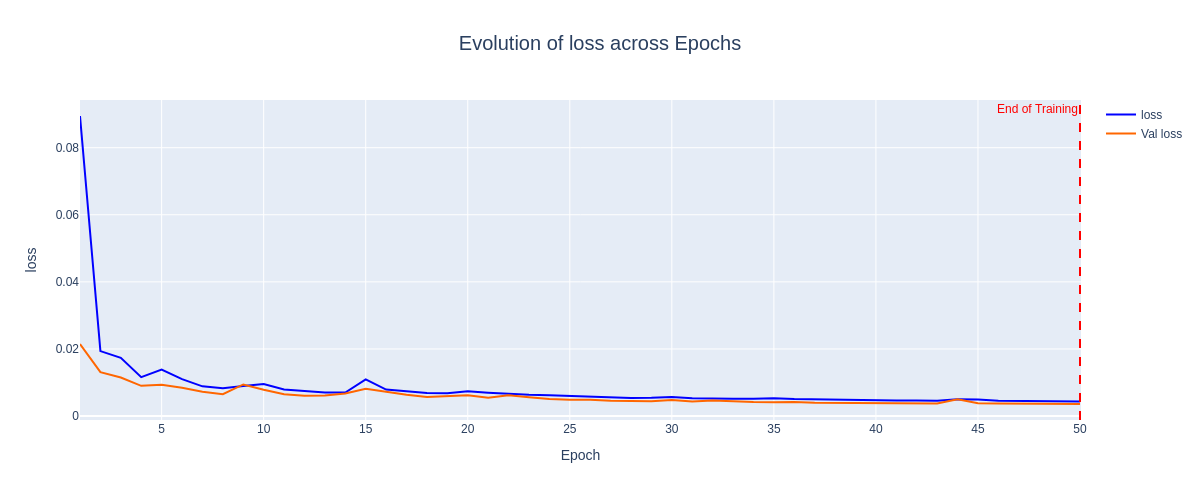

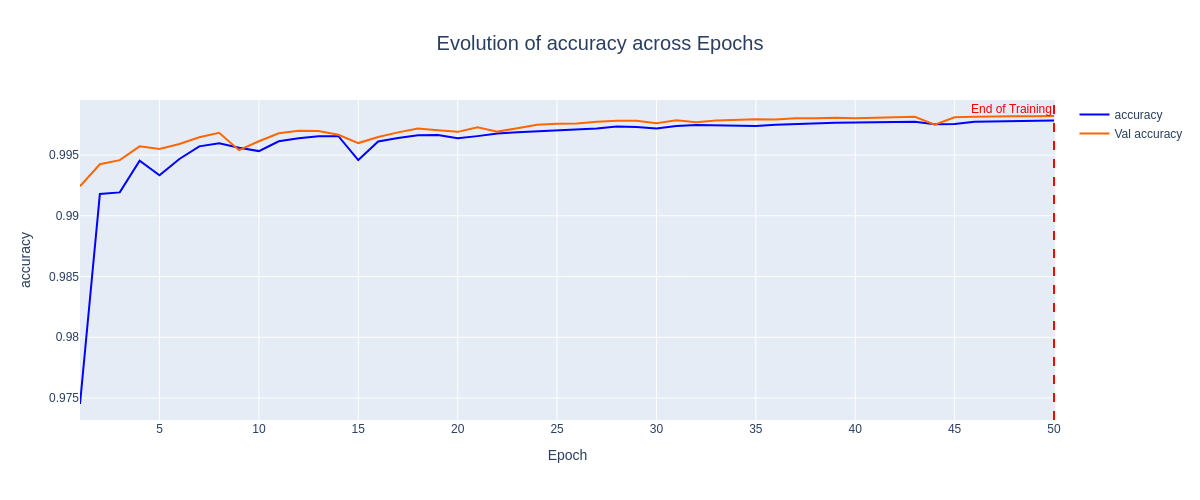

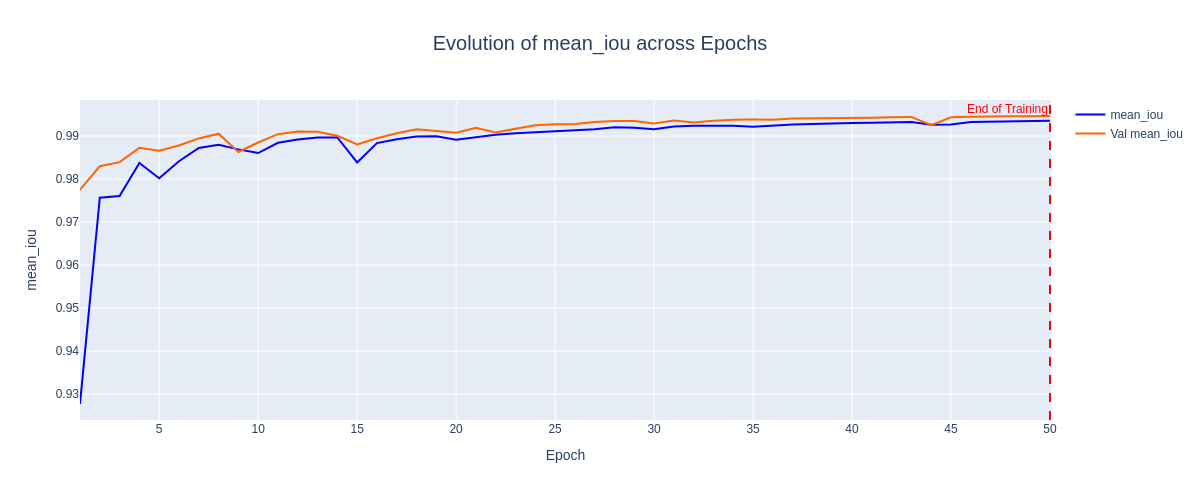

In [ ]:
# Static image for GitHub
plot_metrics(history, idxmax, metrics=list(history.keys())[:3], renderer="png")

### **Mean IoU and Dice Score**

In [ ]:
# Instantiate the segmentation metrics
mean_iou = SegmentationMetrics(
    metric_name="mean_iou",
    num_classes=num_classes,
    device=device
)

dice_score = SegmentationMetrics(
    metric_name="dice_score",
    num_classes=num_classes,
    device=device
)

In [ ]:
# Extract the components of the validation dataset, make predictions, and update the metrics
model.eval()

images_val, masks_val, masks_val_pred = [], [], []

with torch.no_grad():
  for images, masks in tqdm(val_dataset):
    masks_pred = model(images.to(device))
    masks_pred = masks_pred.argmax(dim=1)

    mean_iou.update(masks_pred, masks, preprocess=False)
    dice_score.update(masks_pred, masks, preprocess=False)

    images_val.append(images.cpu())
    masks_val.append(masks.cpu())
    masks_val_pred.append(masks_pred.cpu())

images_val = torch.cat(images_val, dim=0)
masks_val = torch.cat(masks_val, dim=0)
masks_val_pred = torch.cat(masks_val_pred, dim=0)

100%|██████████| 64/64 [00:50<00:00,  1.26it/s]


In [ ]:
# Create a DataFrame with the metrics for each class
df_val = pd.DataFrame({
    "Class": class_names,
    "IoU": mean_iou.compute_by_class().cpu(),
    "Dice Score": dice_score.compute_by_class().cpu()
})
df_val

Class       IoU  Dice Score
0  background  0.997738    0.998868
1         car  0.991568    0.995766

In [ ]:
df_val.IoU.mean(), df_val["Dice Score"].mean()

(0.99465305, 0.99731696)

## **Inference with the Trained Model**

### **Validation Dataset**

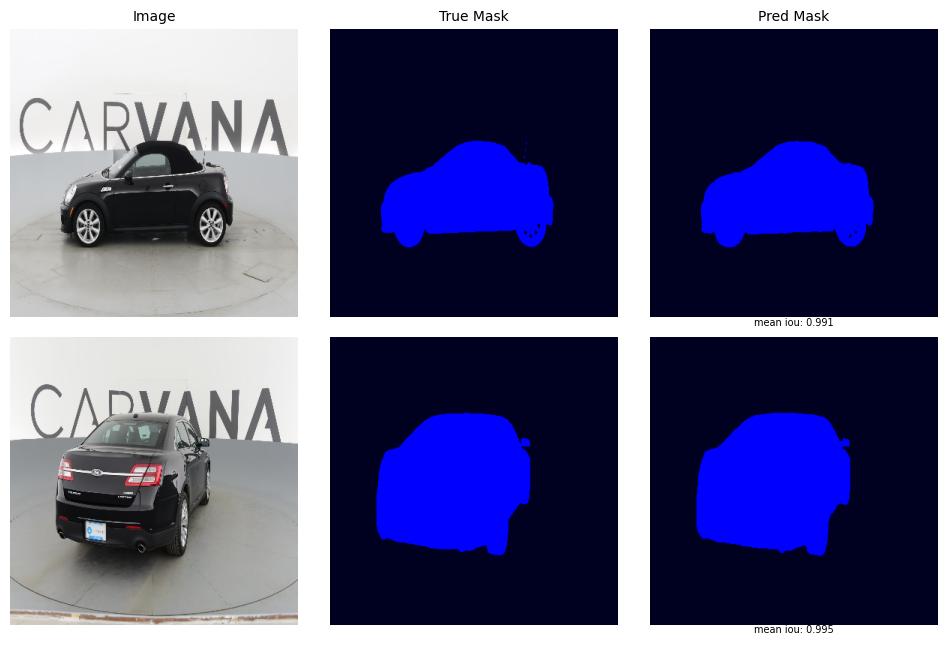

In [ ]:
plot_image_masks(images_val, masks_val, masks_val_pred, n_rows=2, metric=mean_iou)

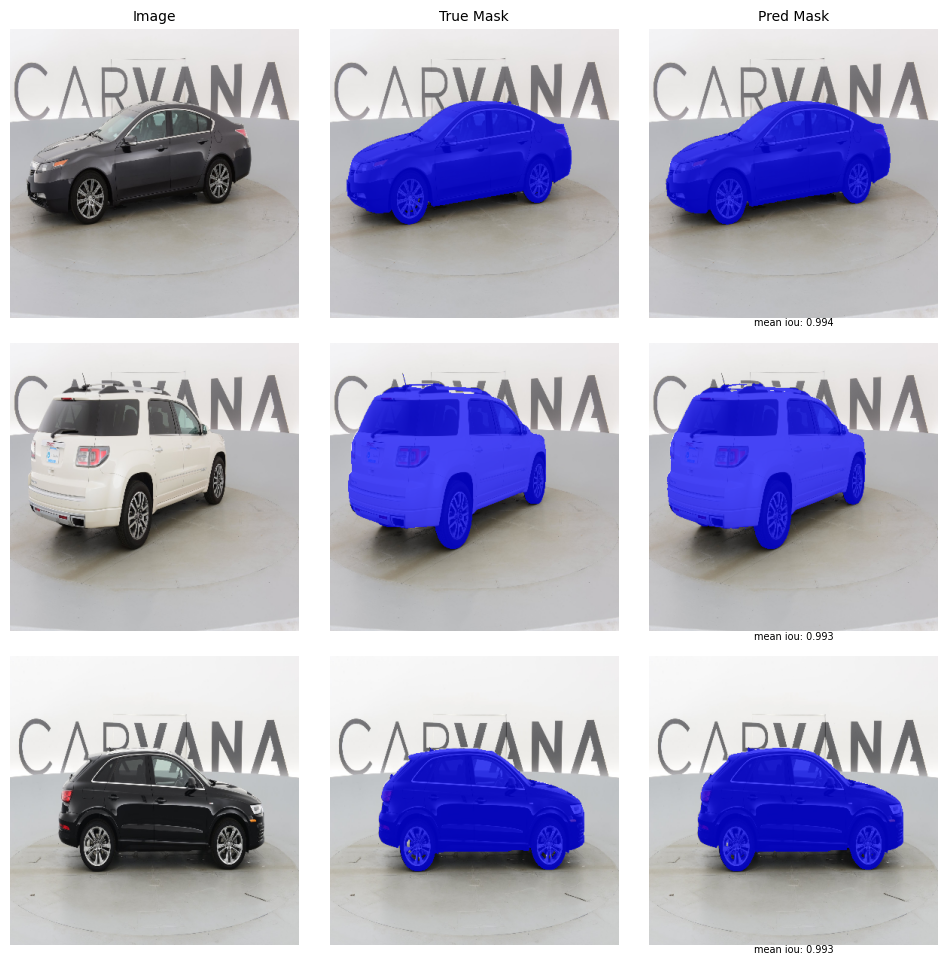

In [ ]:
plot_image_masks(images_val, masks_val, masks_val_pred, random=False, blended=True, metric=mean_iou)

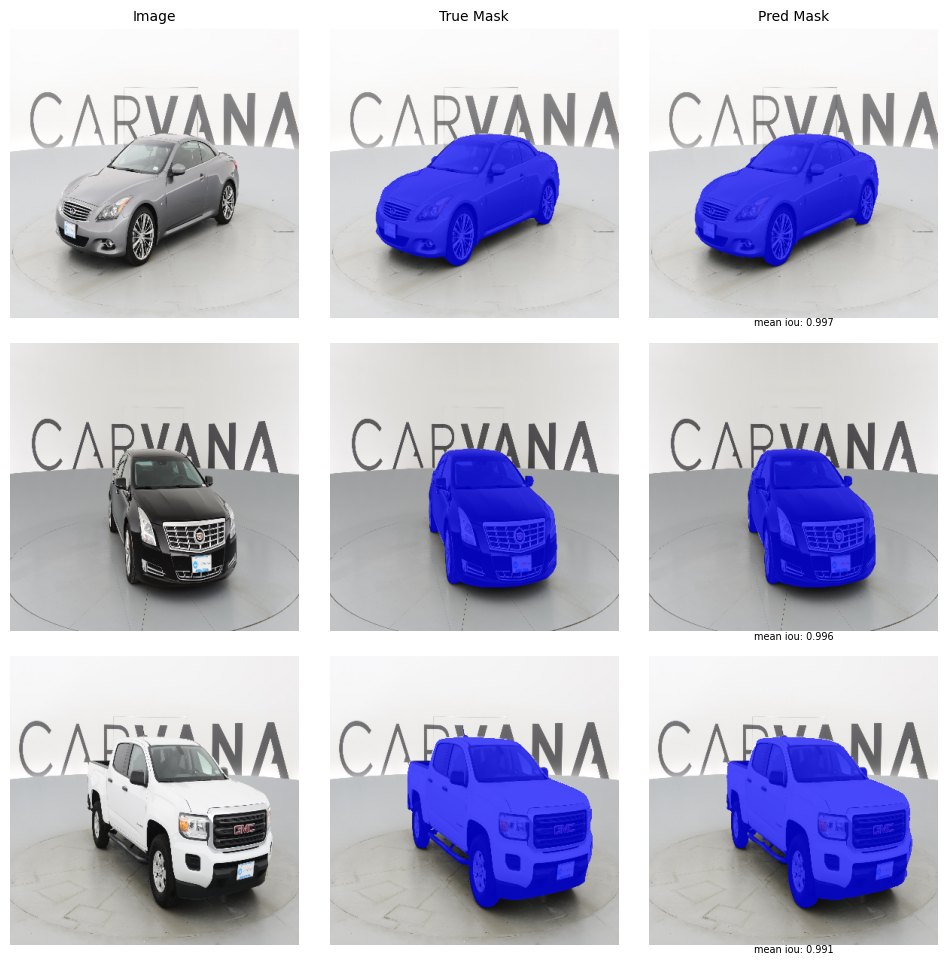

In [ ]:
plot_image_masks(images_val, masks_val, masks_val_pred, blended=True, metric=mean_iou)

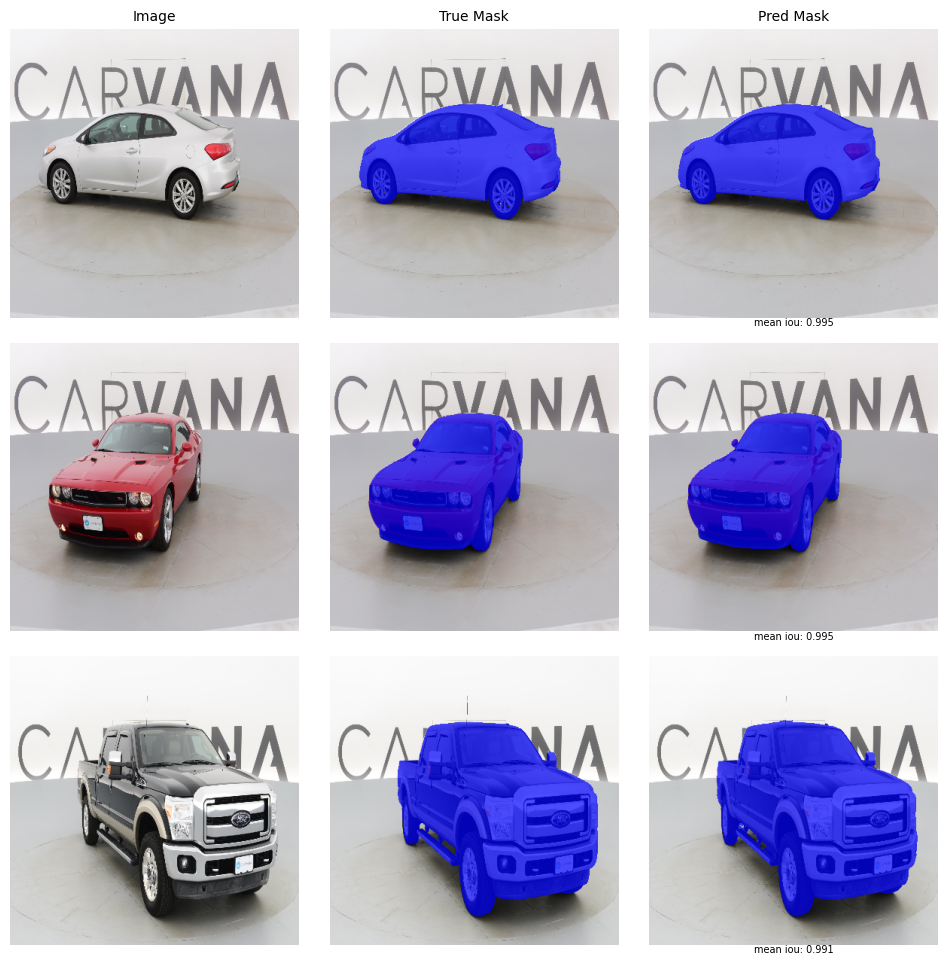

In [ ]:
plot_image_masks(
    images_val, masks_val, masks_val_pred,
    blended=True, metric=mean_iou, save=True,
    path_save="BinarySegmentation_U-Net_Carvana_1.png"
)

### **Internet Images**

In [ ]:
# Load the weights of the trained model
model = UNet(num_classes).to(device)
model.load_state_dict(torch.load(trained_model_path, weights_only=True))

<All keys matched successfully>

In [ ]:
# Function for semantic segmentation with images from the internet
def carvana_segmentation(model, list_urls, n_rows=3, alpha=0.7, save=False, path_save=""):

  model.eval()

  # Download the images and convert them to NumPy arrays
  images = []
  for url in list_urls[:n_rows]:
    response = requests.get(url)
    image = Image.open(io.BytesIO(response.content)).convert("RGB")
    images.append(np.array(image.resize(image_size[1:])))

  # Preprocess the images
  images = torch.stack([torch.tensor(img, dtype=torch.float32).permute(2, 0, 1) for img in images], dim=0)
  images /= 255

  # Predict segmentation masks
  with torch.no_grad():
    masks_pred = model(images.to(device))
    masks_pred = masks_pred.argmax(dim=1).cpu()

  fig, ax = plt.subplots(n_rows, 3, figsize=(3.25 * 3, 3.25 * n_rows))
  ax[0, 0].set_title("Image", fontsize=10)
  ax[0, 1].set_title("Pred Mask", fontsize=10)
  ax[0, 2].set_title("Blended Image", fontsize=10)

  for i in range(n_rows):
    image = images[i].permute(1, 2, 0).numpy()
    mask_cls = masks_pred[i].numpy()
    mask_rgb = class_colors[mask_cls] / 255

    mask_rgb = mask_rgb.astype(image.dtype)
    mask_rgb[mask_cls == background_class] = image[mask_cls == background_class]
    blended_image = cv2.addWeighted(image, 1 - alpha, mask_rgb, alpha, 0)

    ax[i, 0].imshow(image)
    ax[i, 1].imshow(class_colors[mask_cls])
    ax[i, 2].imshow(blended_image)

    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
    ax[i, 2].axis("off")

  plt.tight_layout()
  # Save images
  if save:
    plt.savefig(path_save)

  plt.show()

In [ ]:
list_urls = [
    "https://vehicle-images.dealerinspire.com/a038-110008857/1FAHP2H8XKG102314/c34b28caec580c44dbd262d3d37a8cf3.jpg",
    "https://cdn4.volusion.store/wahx3-tkt3o/v/vspfiles/photos/10-04-MIN-010-2.jpg?v-cache=1681288204",
    "https://autoimage.capitalone.com/dealer/2016-Ford-F250_Super_Duty_Crew_Cab-XL_Pickup_4D_6_3/4_ft-1FT7W2BT7GEB50507-dealercenter_1FT7W2BT7GEB50507_18572922-50de6a486ba44c980841fa49fb2e71cc-bg_2.jpg?width=640&height=480",
    "https://static.cargurus.com/images/forsale/2025/01/03/19/19/2016_mazda_mazda6-pic-4962517103741082742-1024x768.jpeg",
    "https://vehicle-images.dealerinspire.com/081e-110007331/19UUA8F5XDA005353/e0332c3bcd5fac53aff6232039969d48.jpg",
    "https://content.homenetiol.com/2000292/2183941/0x0/stock_images/8/2016FRD010a_640/2016FRD010a_640_02.jpg"
]

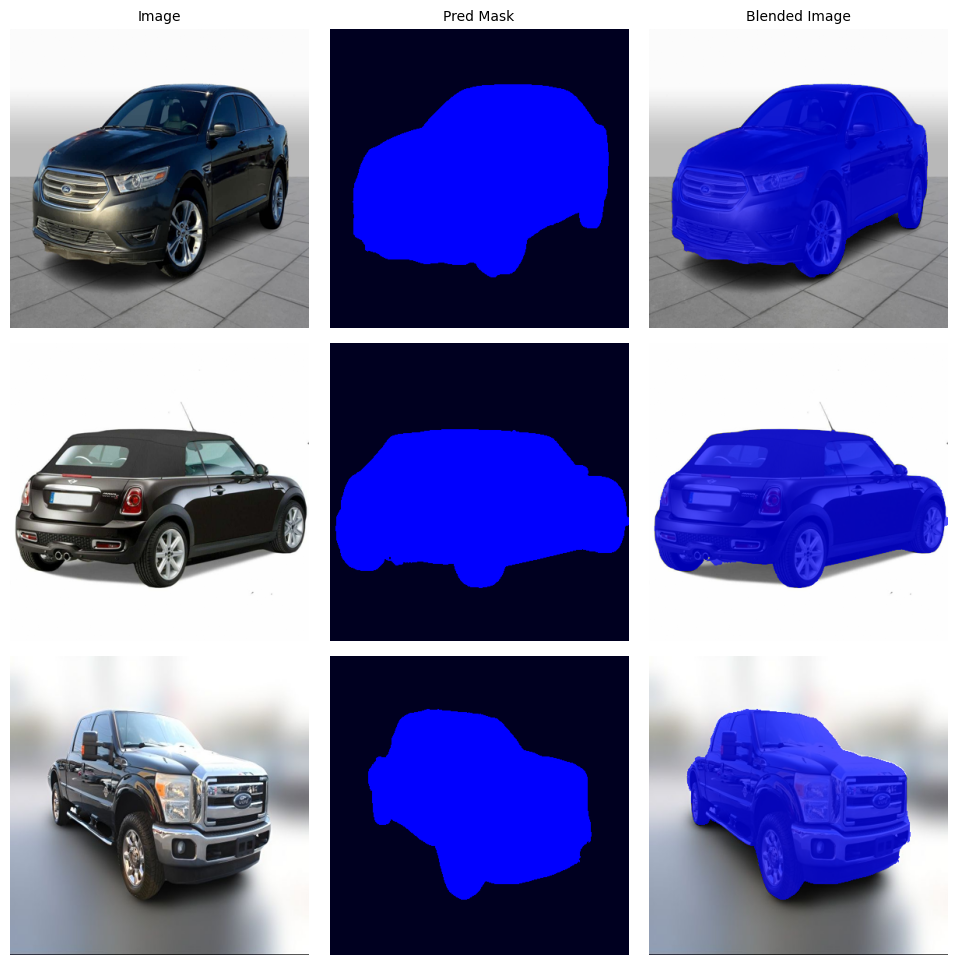

In [ ]:
carvana_segmentation(
    model, list_urls, save=True,
    path_save="BinarySegmentation_U-Net_Carvana_2.png"
)

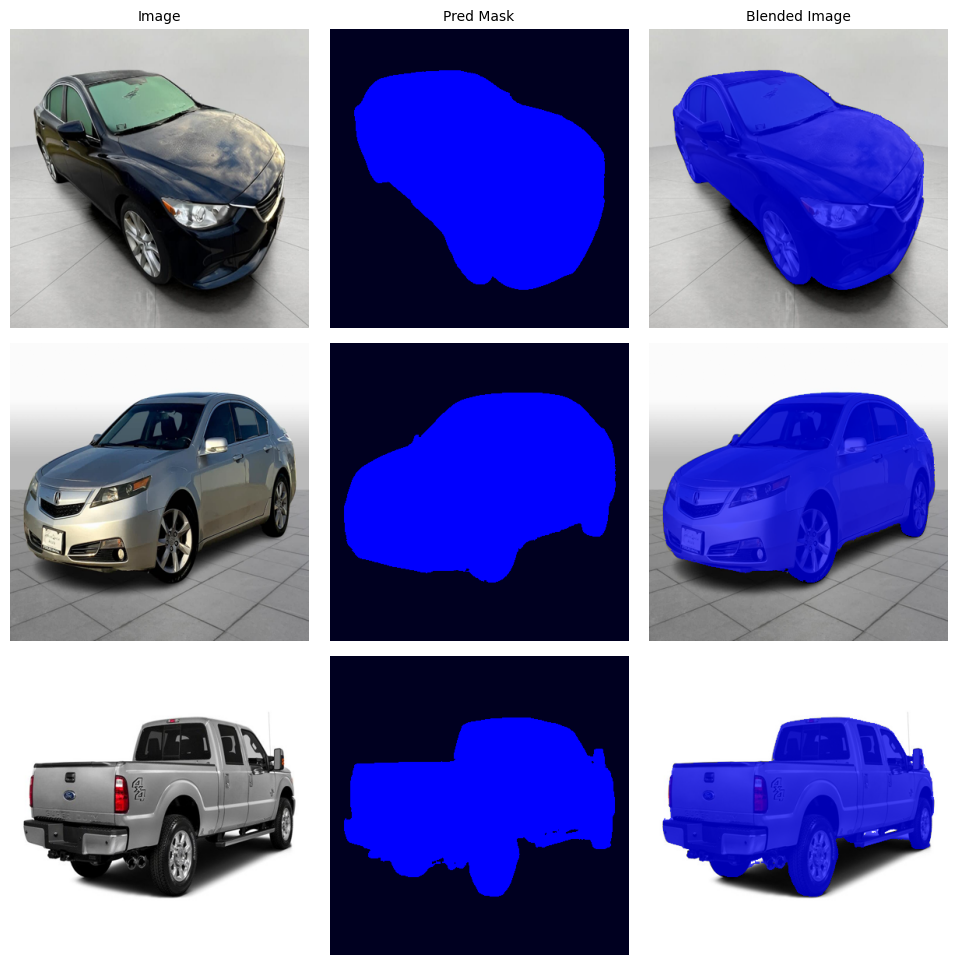

In [ ]:
carvana_segmentation(model, list_urls[3:])

## **Conclusion**

The modified **U-Net** model achieved a **Mean IoU** of **0.9935** on the **training dataset** and a **Mean IoU** of **0.9947** with a **Dice Score** of **0.9973** on the **validation dataset**. These results indicate outstanding performance, segmenting car images almost perfectly. Additionally, there is no evidence of overfitting, suggesting that techniques like data augmentation and the use of a learning rate scheduler were effective. 

Metric graphs suggest that the model might slightly improve with a few more epochs, but the gains would be minimal. Therefore, training for **50 epochs** is sufficient for this dataset. It is also worth noting that the use of **generalized dice loss** played a crucial role, helping to address the class imbalance and achieving nearly identical segmentation metrics for the **background** and **car** classes in the validation dataset.

However, it is essential to consider that the **Carvana Image Masking** dataset consists of car images with nearly clean backgrounds and a single car per image, which explains the model's high performance. While the model produces nearly perfect results for images meeting these criteria, its performance significantly degrades when dealing with images containing multiple cars or complex backgrounds.

If the goal is to develop a model capable of segmenting vehicles in more diverse and challenging scenarios, the training dataset would need to be expanded to include more varied images. Nevertheless, for a basic binary car segmentation model, this model is nearly perfect.